In [5]:
from __future__ import absolute_import, division, print_function

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"



import sys
import os

import pandas as pd
import numpy as np

#TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

#Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: "%.5f" % x) #pandas
np.set_printoptions(precision = 5, suppress = True) #numpy

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

#seaborn plotting style
sns.set(style = "ticks", context = "poster")

In [7]:
filename_ts = "2_f_1.csv"
ts_df = pd.read_csv('2_f_1.csv', header=None, names=['value'])
n_sample = ts_df.shape[0]
print(ts_df.shape)
print(ts_df.head())

(300, 1)
   value
0    958
1    978
2   1020
3   1062
4   1081


In [10]:
#Create a training sample and testing sample before analyzing the series
n_train = int(0.95*n_sample)+1
n_forecast = n_sample-n_train

#ts_df
ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(286,)
(14,)
Training Series: 
 281    972
282    956
283    902
284    863
285    858
Name: value, dtype: int64 

Testing Series: 
 286    906
287    968
288    991
289    968
290    941
Name: value, dtype: int64


In [11]:
def tsplot (y, lags = None, title = " ",figsize = (14,8)):
    fig = plt.figure(figsize = figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax = ts_ax)
    ts_ax.set_title(title)
    y.plot(ax = hist_ax, kind = "hist", bins = 25)
    hist_ax.set_title("Histogram")
    sm.graphics.tsa.plot_acf(y, lags = lags, ax = acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags = lags, ax = pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x241b0294710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x241af804668>)

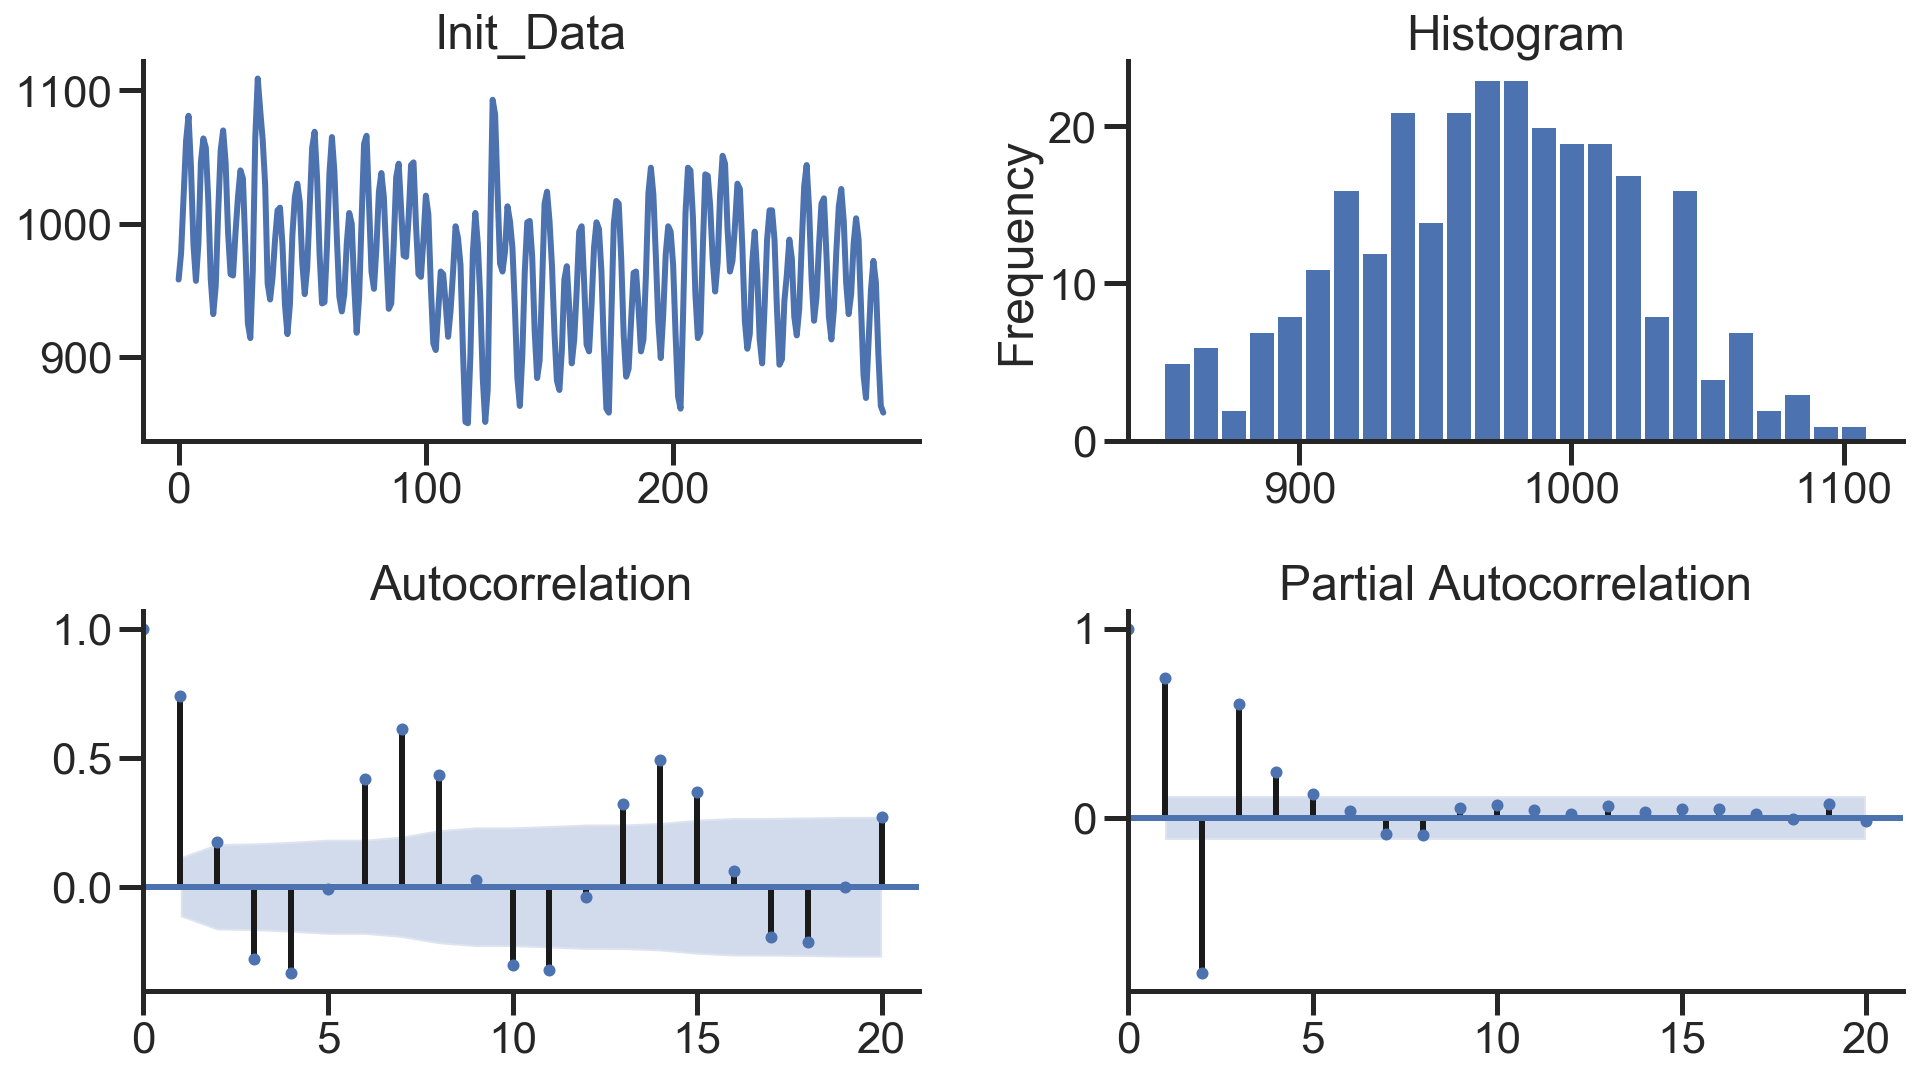

In [13]:
tsplot(ts_train, title = "Init_Data", lags=20)

In [14]:
#Model Estimation

#Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order = (2,0,0))
model_results = arima200.fit()

In [15]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

#Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index = ["AR{}".format(i) for i in range(p_min, p_max+1)],
                          columns = ["MA{}".format(i) for i in range(q_min ,q_max+1)])

for p, d, q in itertools.product(range(p_min, p_max+1),
                                range(d_min, d_max+1),
                                range(q_min, q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc["AR{}".format(p), "MA{}".format(q)] = np.nan
        continue
    try:
        model = sm.tsa.SARIMAX(ts_train, order = (p, d, q),
                              #enforce_stationarity = False,
                              #enforce_invertibility = False,
                              )
        results = model.fit()
        results_bic.loc["AR{}".format(p),"MA{}".format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-pac

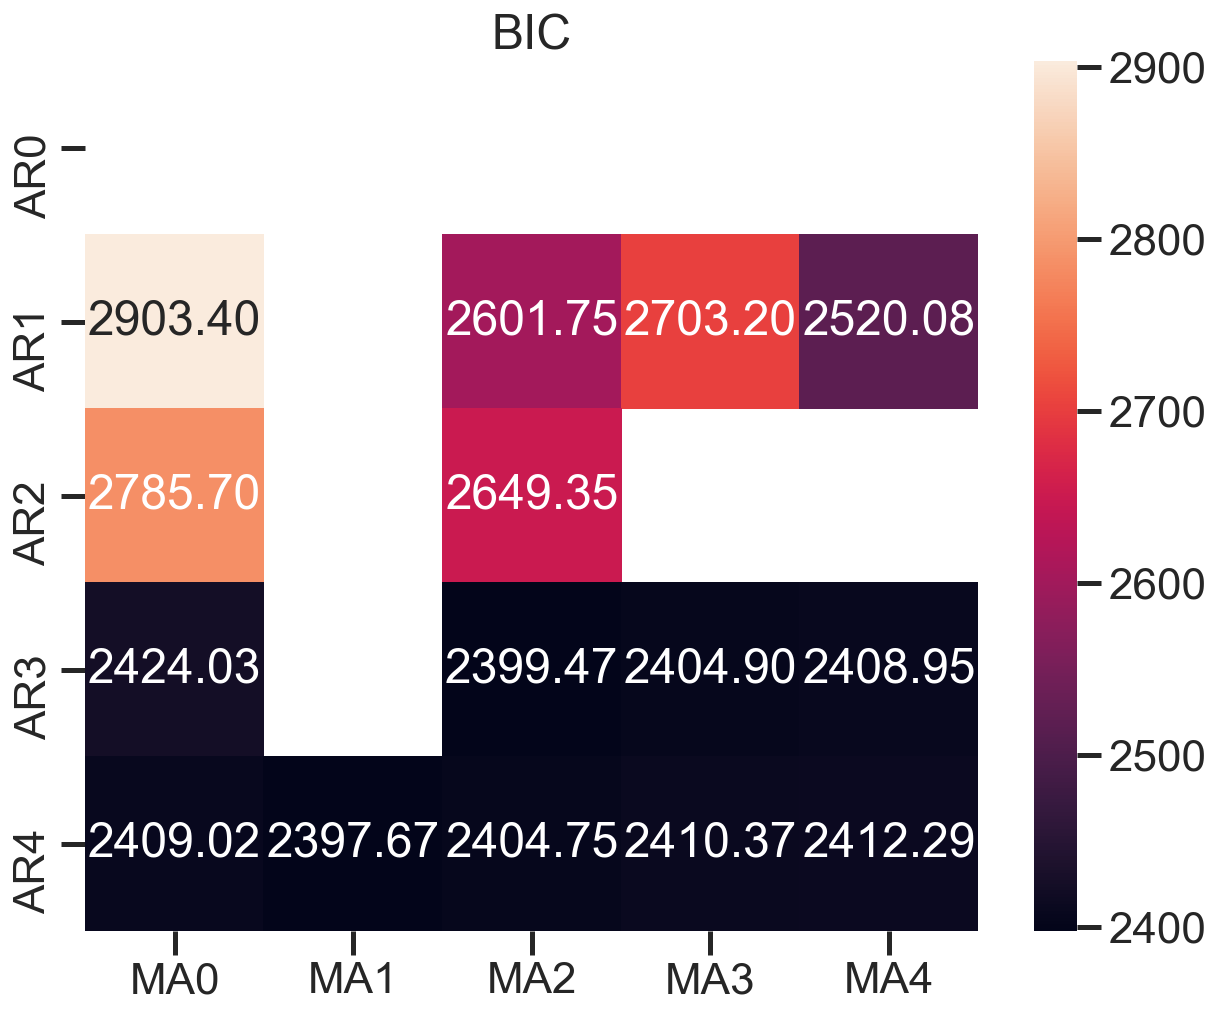

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(results_bic,
                mask  = results_bic.isnull(),
                ax = ax,
                annot = True,
                fmt = ".2f",
                );
ax.set_title("BIC");


In [17]:
def BICHeatMap (ts_train, p_min = 0, d_min = 0, q_min = 0, p_max = 4,d_max = 0, q_max = 4 ):
    #Initialize a DataFrame to store the results
    results_bic = pd.DataFrame(index = ["AR{}".format(i) for i in range(p_min, p_max+1)],
                              columns = ["MA{}".format(i) for i in range(q_min ,q_max+1)])

    for p, d, q in itertools.product(range(p_min, p_max+1),
                                    range(d_min, d_max+1),
                                    range(q_min, q_max+1)):
        if p==0 and d==0 and q==0:
            results_bic.loc["AR{}".format(p), "MA{}".format(q)] = np.nan
            continue
        try:
            model = sm.tsa.SARIMAX(ts_train, order = (p, d, q),
                                  #enforce_stationarity = False,
                                  #enforce_invertibility = False,
                                  )
            results = model.fit()
            results_bic.loc["AR{}".format(p),"MA{}".format(q)] = results.bic
        except:
            continue
    results_bic = results_bic[results_bic.columns].astype(float)
    fig, ax = plt.subplots(figsize = (10, 8))
    ax = sns.heatmap(results_bic,
                    mask  = results_bic.isnull(),
                    ax = ax,
                    annot = True,
                    fmt = ".2f",
                    );
    ax.set_title("BIC");

c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-pac

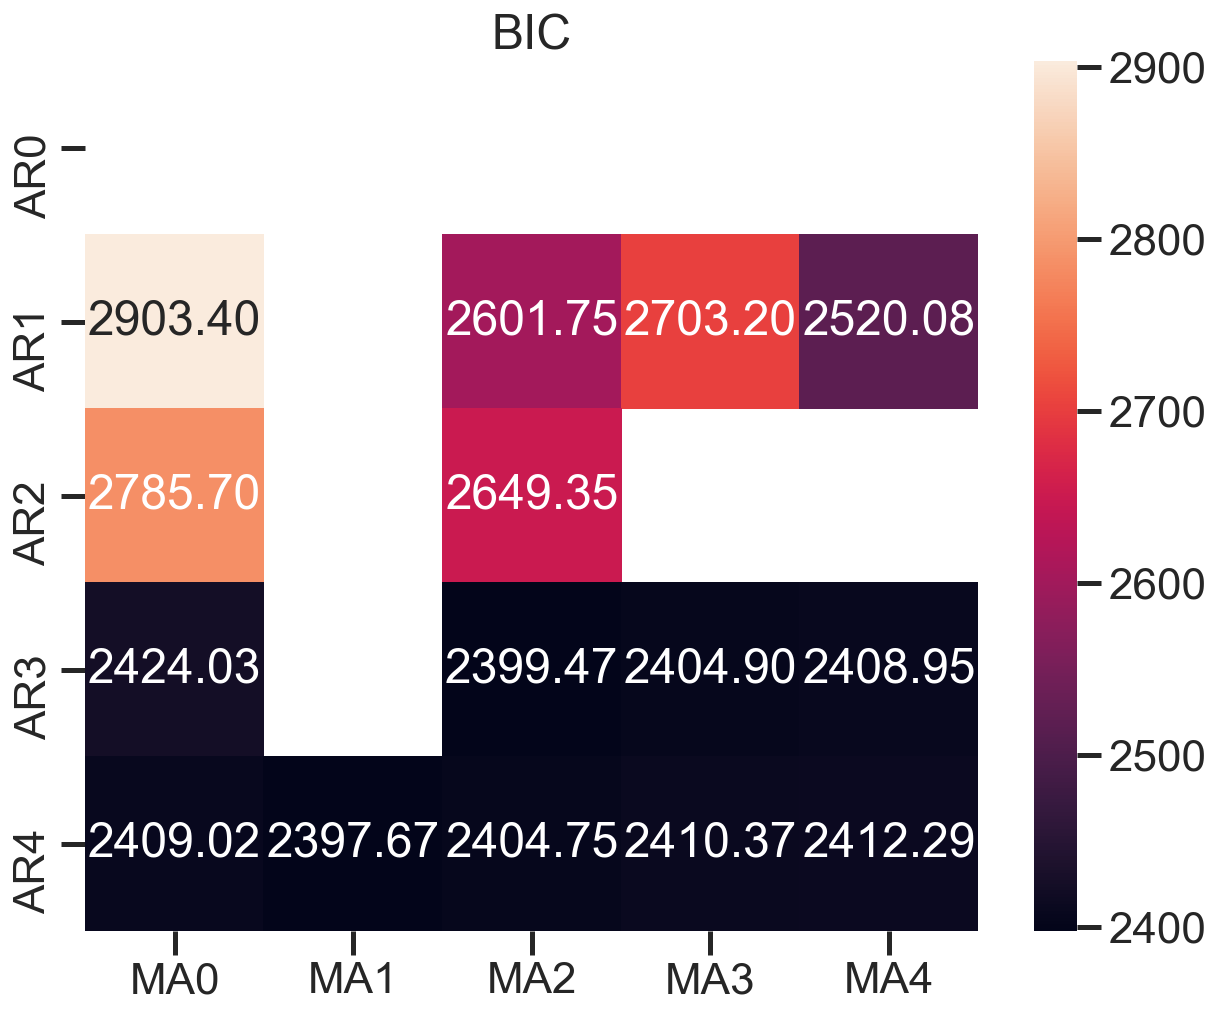

In [18]:
BICHeatMap(ts_train)

c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-pac

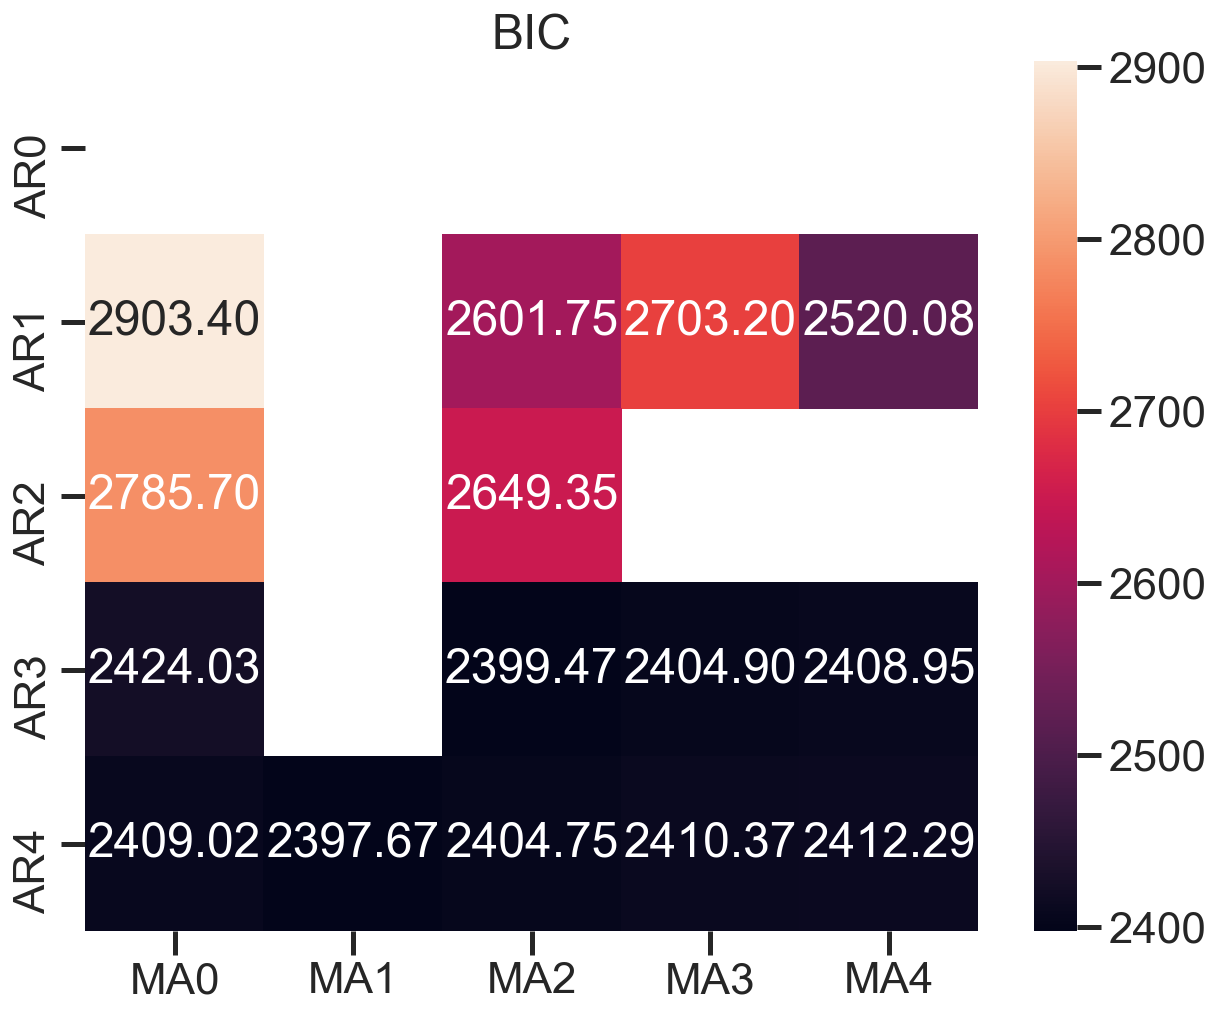

In [20]:
BICHeatMap(ts_train)

In [23]:
# Alternative model selection method, limited to only searching AR and MA parameters

train_results = sm.tsa.arma_order_select_ic(ts_train, ic = ["aic", "bic"], trend = "nc", max_ar = 4, max_ma = 4)

print("AIC", train_results.aic_min_order)
print("BIC", train_results.bic_min_order)

c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
c:\users\mtx\appdata\local\programs\pyt

AIC (4, 1)
BIC (3, 1)


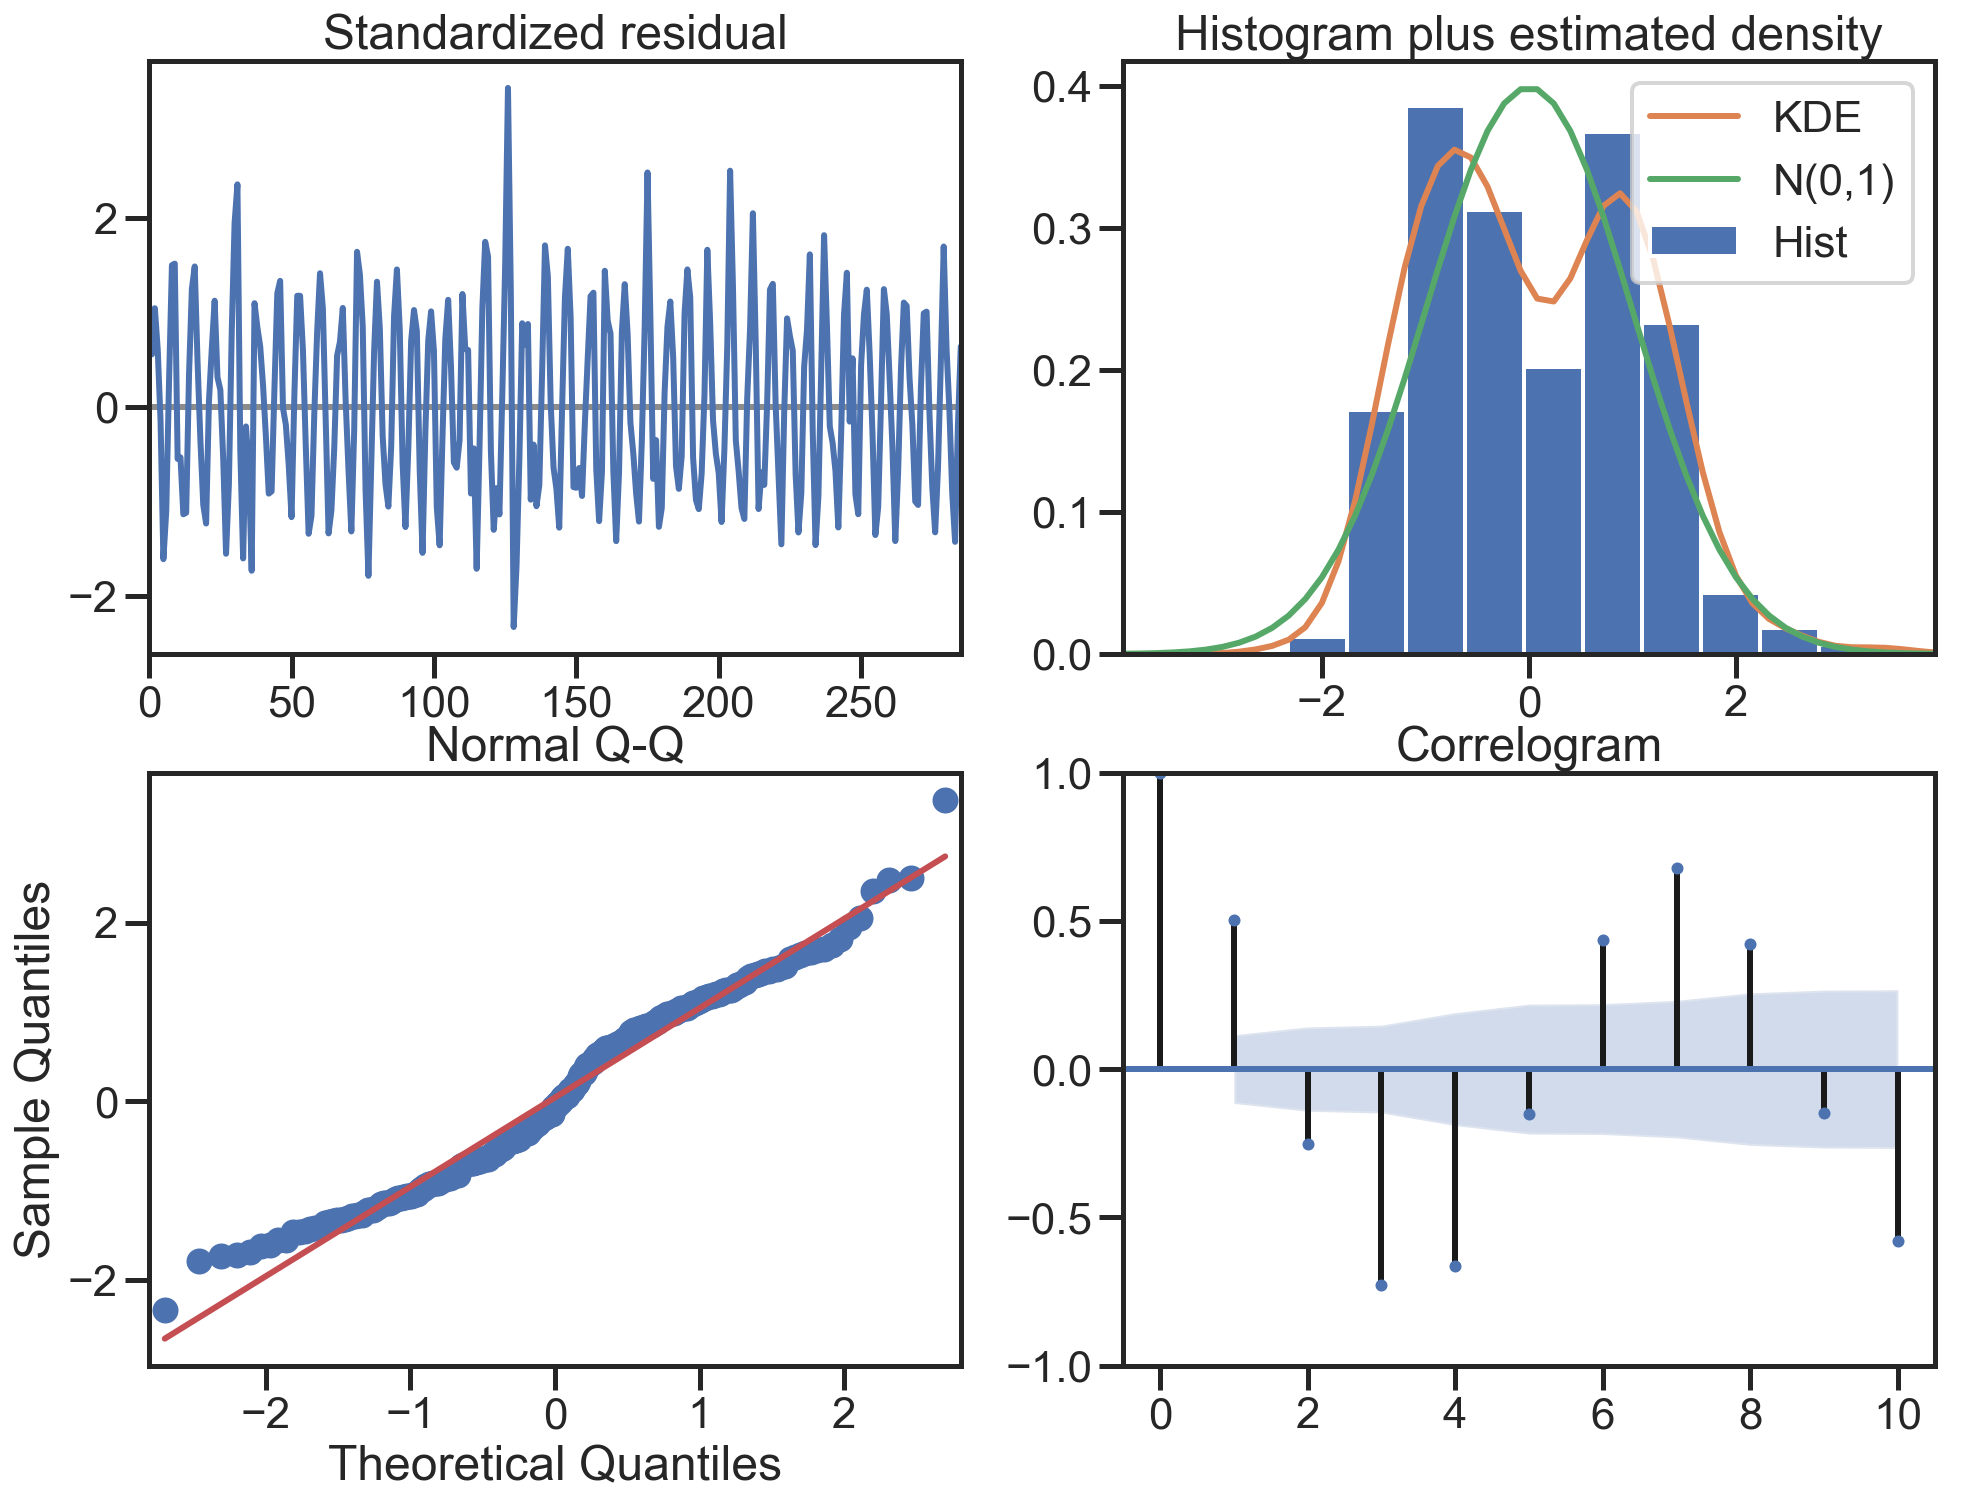

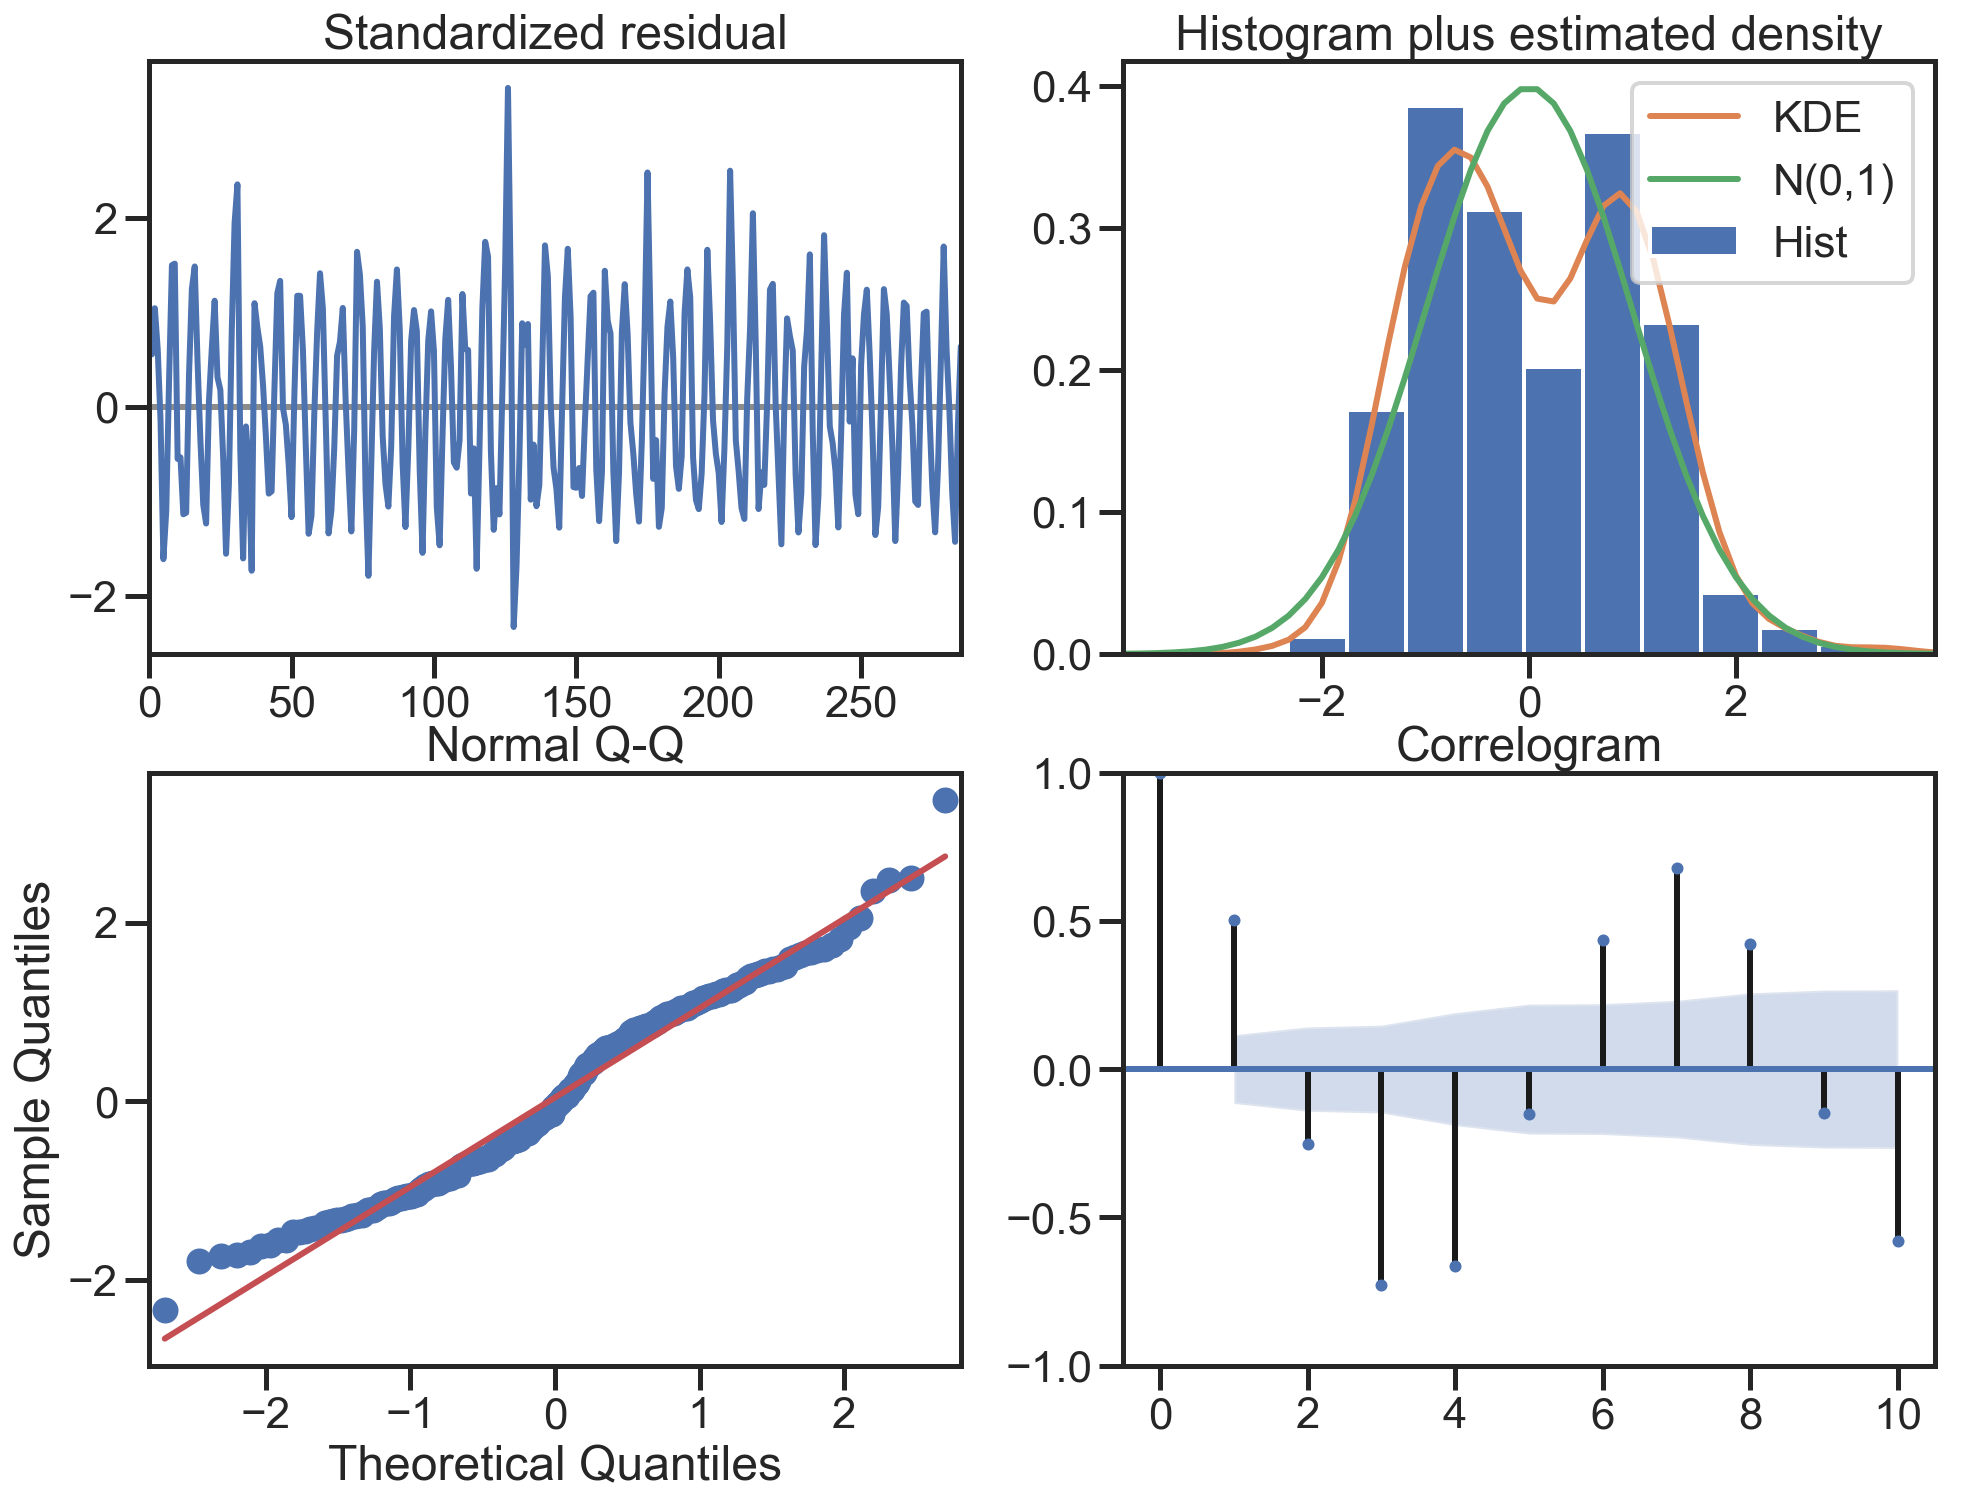

In [24]:
model_results.plot_diagnostics(figsize = (16,12))

In [33]:
#Fit the model
arima401 = sm.tsa.SARIMAX(ts_train, order = (4,0,1))
model_results = arima401.fit()


c:\users\mtx\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [36]:
import statsmodels as sm
arma_mod = sm.tsa.arima_model.ARMA(ts_train,(4,0,1)).fit(disp=-1,method='mle')
summary = (arma_mod.summary2(alpha=.05, float_format="%.8f"))
print(summary)

                           Results: ARMA
Model:              ARMA             BIC:                 2388.7520
Dependent Variable: value            Log-Likelihood:      -1177.4  
Date:               2020-05-21 15:31 Scale:               1.0000   
No. Observations:   286              Method:              mle      
Df Model:           5                Sample:              0        
Df Residuals:       281                                   6        
Converged:          1.0000           S.D. of innovations: 14.722   
No. Iterations:     22.0000          HQIC:                2375.609 
AIC:                2366.8160                                      
-------------------------------------------------------------------
                 Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-------------------------------------------------------------------
const           970.9409   6.5300 148.6884 0.0000 958.1423 983.7395
ar.L1.value       1.7848   0.0582  30.6729 0.0000   1.6708   1.8988
ar.L2.v

In [37]:
resid = arma_mod.resid
t=sm.tsa.stattools.adfuller(resid)
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

                               value
Test Statistic Value        -9.52309
p-value                      0.00000
Lags Used                          2
Number of Observations Used      283
Critical Value(1%)          -3.45367
Critical Value(5%)          -2.87181
Critical Value(10%)         -2.57224


In [39]:
arma_model = sm.tsa.arima_model.ARMA(ts_train,(4,1)).fit(disp=-1,maxiter=100)
predict_data = arma_model.predict(start=286, end=299, dynamic = False)

In [40]:
print(predict_data)

286   895.61431
287   948.75981
288   981.40539
289   975.37062
290   941.42601
291   908.74945
292   902.43284
293   926.17055
294   961.84633
295   984.58778
296   981.06263
297   957.74534
298   934.32971
299   928.46196
dtype: float64


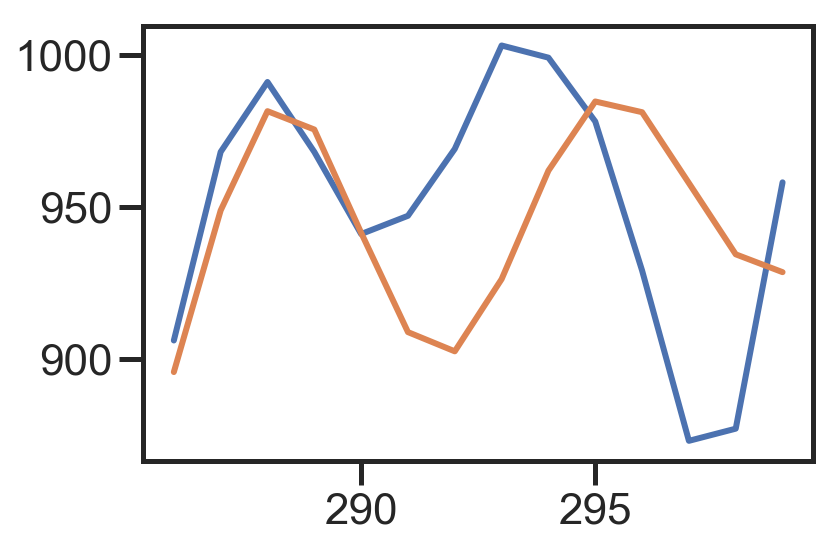

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ts_test)
ax.plot(predict_data)